In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5], \
                          [5,6,7,8],[1,3,4,5]]], \
                [[[-1,2,3,-4],[2,-3,4,5], \
            [-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()

In [3]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [4]:
from torchsummary import summary

In [5]:
model, loss_fn, optimizer = get_model()
summary(model, X_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    opt.zero_grad()
    pred = model(x)
    batch_loss = loss_fn(pred.squeeze(0), y)
    batch_loss.backward()
    opt.step()
    return batch_loss.item()

In [10]:
train_dl = DataLoader(TensorDataset(X_train, y_train))

In [11]:
for epoch in range(2000):
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [12]:
model(X_train[:1])

tensor([[0.1233]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [13]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [14]:
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer, 'weight')]

In [15]:
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

In [16]:
for i in range(h_im - h_conv + 1):
    for j in range(w_im - w_conv + 1):
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        model_filter = cnn_w.reshape(3,3)
        val = torch.sum(img_subset*model_filter) + cnn_b
        sumprod[i,j] = val

In [24]:
data_folder = '~/data/FMNIST' # This can be any directory you 
# want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, \
                                        train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

fmnist = datasets.FashionMNIST(data_folder, download=True, \
                                        train=False)
val_images = fmnist.data
val_targets = fmnist.targets

In [18]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [19]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [20]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [25]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), 
                                            shuffle=False)
    return trn_dl, val_dl

In [26]:
train_dl, val_dl = get_data()

In [27]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [28]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [29]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, \
                                                loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

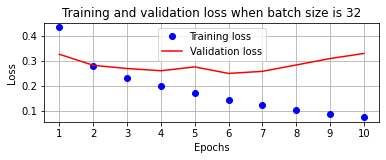

<ipython-input-30-3b9a7c2489c4>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


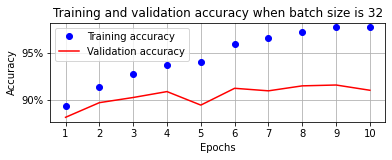

In [30]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
         label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
         label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

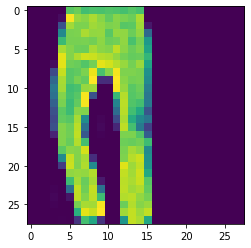

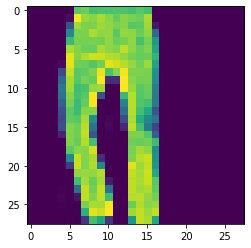

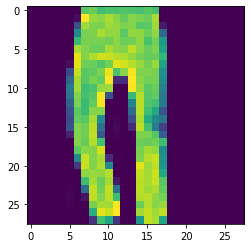

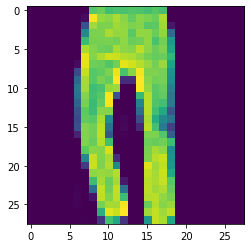

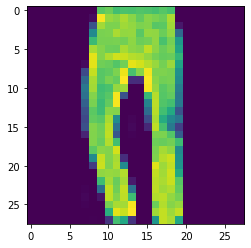

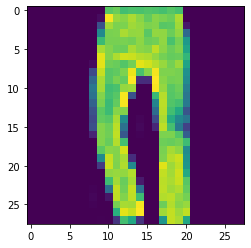

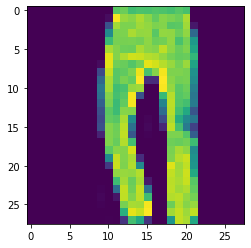

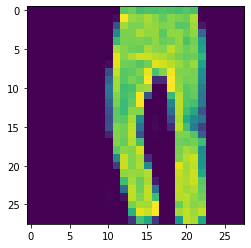

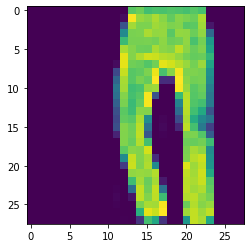

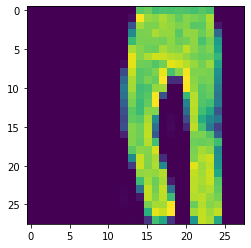

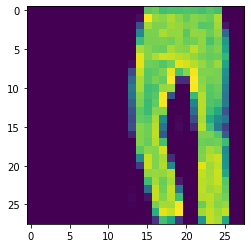

In [31]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<AxesSubplot:title={'center':'Probability of each class for various translations'}>

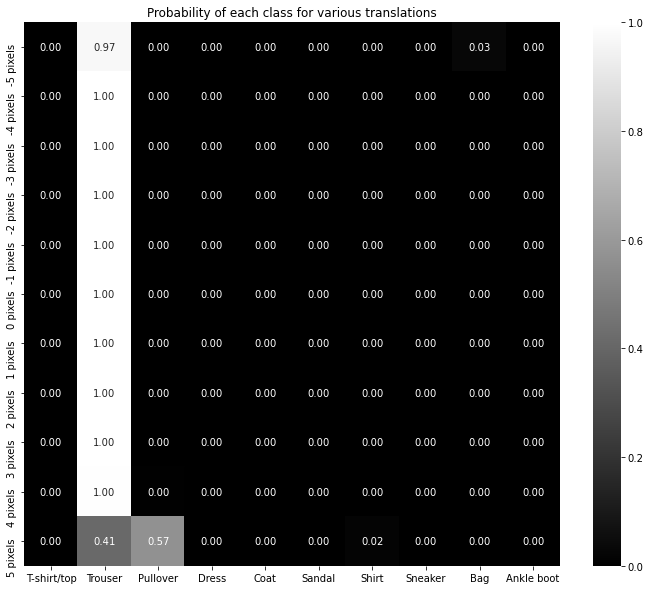

In [33]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for \
various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, \
            ax=ax, fmt='.2f', xticklabels=fmnist.classes, \
            yticklabels=[str(i)+str(' pixels') \
                         for i in range(-5,6)], cmap='gray')

In [35]:
from torchvision import datasets
import torch
data_folder = '~/data/FashionMNIST' # This can be any directory 
# you download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, \
                               train=True)

93.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
tr_images = fmnist.data
tr_targets = fmnist.targets

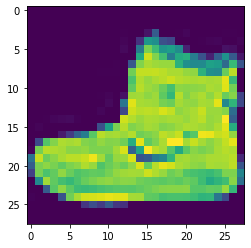

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(tr_images[0])

In [38]:
from imgaug import augmenters as iaa

In [39]:
aug = iaa.Affine(scale=2)

Text(0.5, 1.0, 'Scaled image')

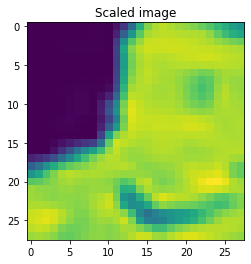

In [46]:
image_aug = aug(image=tr_images[0].numpy())

plt.imshow(image_aug)
plt.title('Scaled image')

In [47]:
aug = iaa.Affine(translate_px=10)

In [48]:
image_aug = aug(image=tr_images[0].numpy())

Text(0.5, 1.0, 'Scaled image')

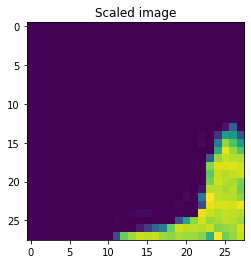

In [49]:
plt.imshow(image_aug)
plt.title('Scaled image')

In [50]:
aug = iaa.Affine(translate_px={'x':10,'y':2})

In [51]:
image_aug = aug(image=tr_images[0].numpy())

Text(0.5, 1.0, 'Scaled image')

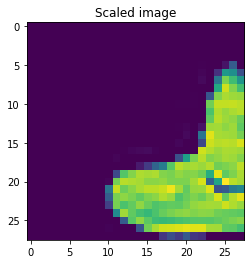

In [52]:
plt.imshow(image_aug)
plt.title('Scaled image')

In [53]:
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)

In [54]:
image_aug = aug(image=tr_images[0].numpy())

Text(0.5, 1.0, 'image')

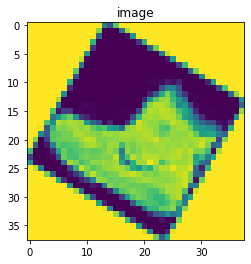

In [55]:
plt.imshow(image_aug)
plt.title('image')

In [56]:
aug = iaa.Sequential([iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),])

In [68]:
from torch.utils.data import Dataset, DataLoader
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x, y
    def __len__(self): return len(self.x)
    
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        if self.aug: ims = self.aug(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [69]:
train = FMNISTDataset(tr_images, tr_targets, aug=aug)

In [70]:
trn_dl = DataLoader(train, batch_size=64,collate_fn=train.collate_fn,shuffle=True)

In [86]:
tr_images = fmnist.data.numpy()
tr_targets = fmnist.targets
val_fmnist=datasets.FashionMNIST(data_folder, download=True, \
                                        train=False)
val_images = val_fmnist.data.numpy()
val_targets = val_fmnist.targets

In [87]:
aug = iaa.Sequential([
              iaa.Affine(translate_px={'x':(-10,10)}, 
                                        mode='constant'),
            ])

In [88]:
def get_model():
    model = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3200, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [89]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [90]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    trn_dl = DataLoader(train, batch_size=64, \
                collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), 
                collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [91]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [92]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, \
                                            loss_fn)